In [1]:
!pip install librosa scikit-learn matplotlib seaborn numpy pandas tensorflow
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import librosa
import librosa.display
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

In [7]:
!pip install kaggle
import os
os.makedirs('/root/.kaggle', exist_ok=True)
from google.colab import files
uploaded = files.upload()
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification
!unzip gtzan-dataset-music-genre-classification.zip -d gtzan_dataset
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
print("Genres:", genres)
for genre in genres:
    genre_path = os.path.join('gtzan_dataset', 'Data', 'genres_original', genre)
    if os.path.exists(genre_path):
        files = [f for f in os.listdir(genre_path) if f.endswith('.wav')]
        print(f"{genre}: {len(files)} files")
    else:
        print(f"Warning: {genre} directory not found")

Saving kaggle (2).json to kaggle (2) (1).json
mv: cannot stat 'kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
License(s): other
100% 1.21G/1.21G [00:12<00:00, 35.2MB/s]
100% 1.21G/1.21G [00:12<00:00, 106MB/s] 
Archive:  gtzan-dataset-music-genre-classification.zip
  inflating: gtzan_dataset/Data/features_30_sec.csv  
  inflating: gtzan_dataset/Data/features_3_sec.csv  
  inflating: gtzan_dataset/Data/genres_original/blues/blues.00000.wav  
  inflating: gtzan_dataset/Data/genres_original/blues/blues.00001.wav  
  inflating: gtzan_dataset/Data/genres_original/blues/blues.00002.wav  
  inflating: gtzan_dataset/Data/genres_original/blues/blues.00003.wav  
  inflating: gtzan_dataset/Data/genres_original/blues/blues.00004.wav  
  inflating: gtzan_dataset/Data/genres_original/blues/blues.00005.wav  
  inflating: gtzan_dataset/Data/genres_original/blues/blues.00006.wav  
  inflating: gtzan_dataset/Dat

In [8]:
def extract_features(file_path, n_mfcc=13, n_mels=128):
    """
    Extract audio features from a music file.
    Returns a dictionary of features.
    """
    try:
        y, sr = librosa.load(file_path, duration=30)
        features = {}
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        for i in range(n_mfcc):
            features[f'mfcc_mean_{i}'] = np.mean(mfcc[i])
            features[f'mfcc_std_{i}'] = np.std(mfcc[i])
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        features['mel_mean'] = np.mean(mel)
        features['mel_std'] = np.std(mel)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        features['chroma_mean'] = np.mean(chroma)
        features['chroma_std'] = np.std(chroma)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        features['centroid_mean'] = np.mean(spectral_centroid)
        features['centroid_std'] = np.std(spectral_centroid)

        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        features['rolloff_mean'] = np.mean(spectral_rolloff)
        features['rolloff_std'] = np.std(spectral_rolloff)

        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        features['bandwidth_mean'] = np.mean(spectral_bandwidth)
        features['bandwidth_std'] = np.std(spectral_bandwidth)
        zcr = librosa.feature.zero_crossing_rate(y)
        features['zcr_mean'] = np.mean(zcr)
        features['zcr_std'] = np.std(zcr)
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        features['tempo'] = tempo
        rms = librosa.feature.rms(y=y)
        features['rms_mean'] = np.mean(rms)
        features['rms_std'] = np.std(rms)

        return features

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [9]:
data = []
labels = []

for genre in genres:
    genre_path = os.path.join('gtzan_dataset', 'Data', 'genres_original', genre)
    if os.path.exists(genre_path):
        files = [f for f in os.listdir(genre_path) if f.endswith('.wav')]
        print(f"Processing {len(files)} {genre} files...")

        for file in files[:50]:
            file_path = os.path.join(genre_path, file)
            features = extract_features(file_path)

            if features:
                data.append(features)
                labels.append(genre)

print(f"Extracted features from {len(data)} audio files")

Processing 100 blues files...
Processing 100 classical files...
Processing 100 country files...
Processing 100 disco files...
Processing 100 hiphop files...
Processing 100 jazz files...
Processing 100 metal files...
Processing 100 pop files...
Processing 100 reggae files...
Processing 100 rock files...
Extracted features from 500 audio files


In [10]:
df = pd.DataFrame(data)
df['genre'] = labels
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nMissing values:")
print(df.isnull().sum())
df = df.dropna()
le = LabelEncoder()
df['genre_encoded'] = le.fit_transform(df['genre'])
X = df.drop(['genre', 'genre_encoded'], axis=1)
y = df['genre_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train_scaled.shape}, Test set: {X_test_scaled.shape}")

Dataset shape: (500, 42)

First few rows:
   mfcc_mean_0  mfcc_std_0  mfcc_mean_1  mfcc_std_1  mfcc_mean_2  mfcc_std_2  \
0  -225.300308   88.708855   117.641518   25.920029   -14.544607   28.568794   
1   -89.391495   26.365196    93.787788   13.877611   -14.571090   11.565832   
2  -177.487350   67.070938   115.333748   37.215866     9.963015   26.121534   
3  -113.194733   39.848755    88.705872   17.779747    -8.925185   15.088199   
4  -213.204529   78.314308   115.154541   28.262222   -11.720503   25.864157   

   mfcc_mean_3  mfcc_std_3  mfcc_mean_4  mfcc_std_4  ...  rolloff_mean  \
0    64.802383   13.206562    12.931657   17.741417  ...   3069.306440   
1    54.391533    9.965017   -33.515018    8.034672  ...   5065.152705   
2    54.056210   17.910526     7.615620   18.185303  ...   3470.729013   
3    49.482689   11.827608   -34.573833   11.089028  ...   5247.468269   
4    39.032555   18.730318   -20.357819   23.071657  ...   3944.584481   

   rolloff_std  bandwidth_mean  

Random Forest Accuracy: 0.6900

Classification Report:
              precision    recall  f1-score   support

       blues       0.50      1.00      0.67        10
   classical       0.83      1.00      0.91        10
     country       0.67      0.60      0.63        10
       disco       0.67      0.60      0.63        10
      hiphop       0.57      0.40      0.47        10
        jazz       0.88      0.70      0.78        10
       metal       0.80      0.80      0.80        10
         pop       0.86      0.60      0.71        10
      reggae       0.64      0.70      0.67        10
        rock       0.71      0.50      0.59        10

    accuracy                           0.69       100
   macro avg       0.71      0.69      0.68       100
weighted avg       0.71      0.69      0.68       100



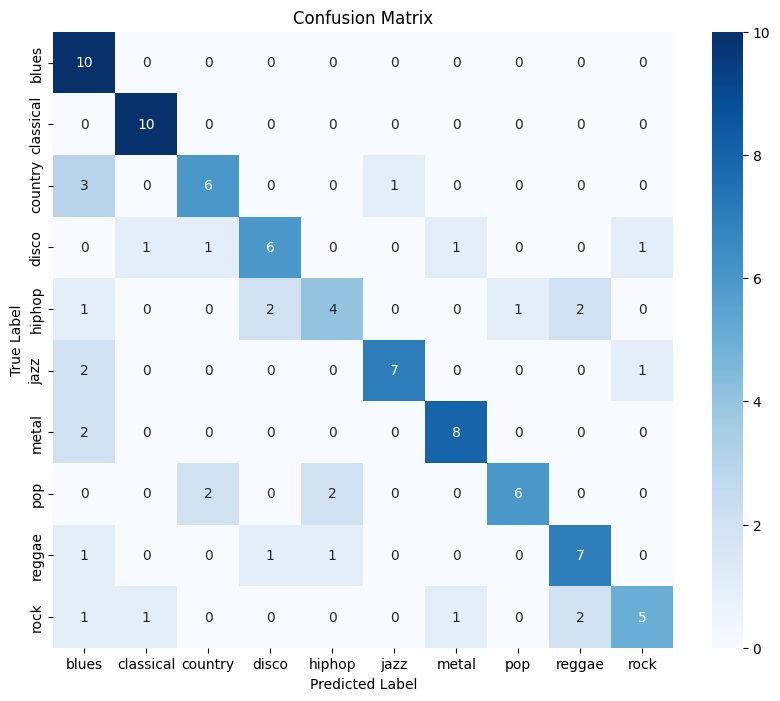

In [11]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)
y_pred = rf_classifier.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

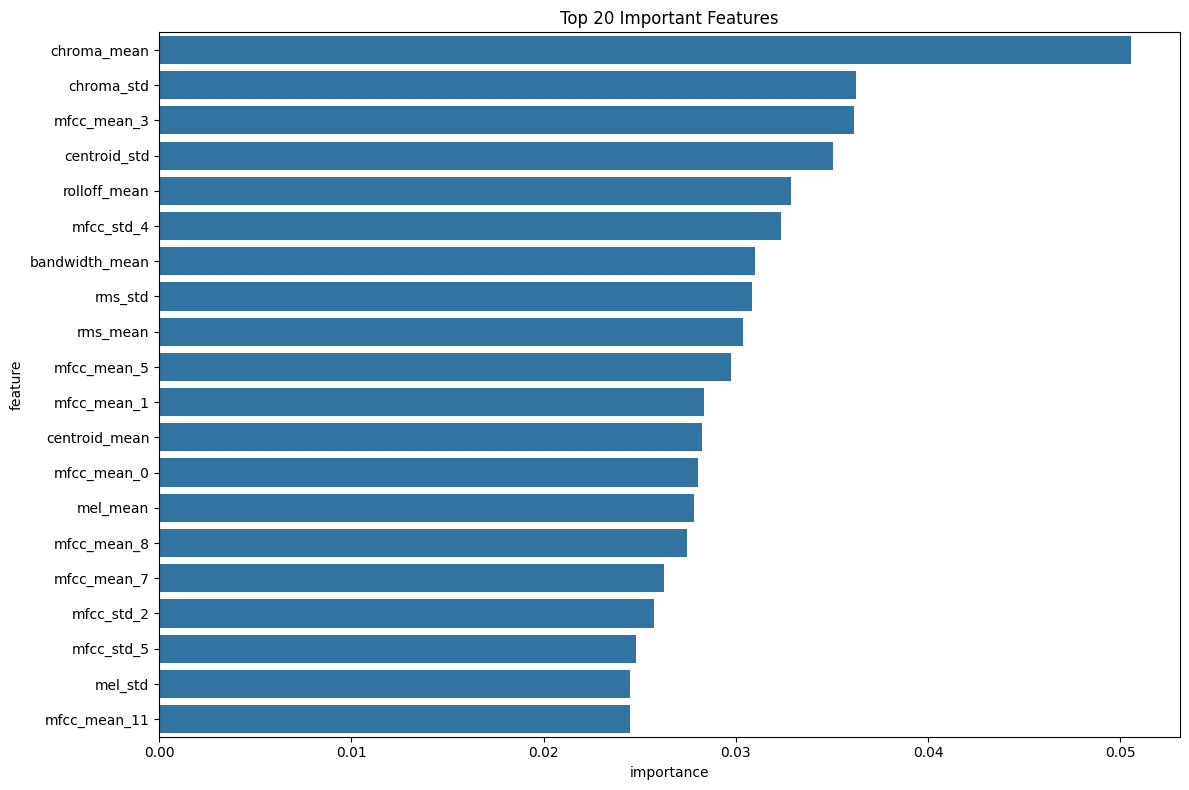

In [12]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Important Features')
plt.tight_layout()
plt.show()

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
def create_spectrogram(file_path, save_path, n_mels=128):
    try:
        y, sr = librosa.load(file_path, duration=30)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        S_dB = librosa.power_to_db(S, ref=np.max)

        plt.figure(figsize=(4, 4))
        librosa.display.specshow(S_dB, sr=sr)
        plt.axis('off')
        plt.tight_layout(pad=0)
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close()
        return True
    except Exception as e:
        print(f"Error creating spectrogram for {file_path}: {e}")
        return False
!mkdir -p spectrograms
for genre in genres:
    !mkdir -p spectrograms/{genre}
print("Generating spectrograms...")
spectrogram_data = []
spectrogram_labels = []

for genre in genres:
    genre_path = os.path.join('gtzan_dataset', 'Data', 'genres_original', genre)
    if os.path.exists(genre_path):
        files = [f for f in os.listdir(genre_path) if f.endswith('.wav')]

        for i, file in enumerate(files[:50]):
            file_path = os.path.join(genre_path, file)
            save_path = f'spectrograms/{genre}/{os.path.splitext(file)[0]}.png'

            if create_spectrogram(file_path, save_path):
                spectrogram_data.append(save_path)
                spectrogram_labels.append(genre)

print(f"Created {len(spectrogram_data)} spectrograms")

Generating spectrograms...
Created 500 spectrograms


In [14]:
def load_images(image_paths, img_size=(128, 128)):
    images = []
    for path in image_paths:
        img = tf.keras.preprocessing.image.load_img(path, target_size=img_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = img_array / 255.0
        images.append(img_array)
    return np.array(images)
X_images = load_images(spectrogram_data)
y_images = le.transform(spectrogram_labels)
y_images_categorical = to_categorical(y_images, num_classes=len(genres))
X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(
    X_images, y_images_categorical, test_size=0.2, random_state=42, stratify=y_images)

print(f"Image dataset shape: {X_train_img.shape}")

Image dataset shape: (400, 128, 128, 3)


In [15]:
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model
cnn_model = create_cnn_model(X_train_img[0].shape, len(genres))
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
cnn_model.summary()
history = cnn_model.fit(X_train_img, y_train_img,
                        epochs=30,
                        batch_size=32,
                        validation_data=(X_test_img, y_test_img),
                        verbose=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,268,298 (12.47 MB)

 Trainable params: 3,268,298 (12.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 898ms/step - accuracy: 0.0853 - loss: 2.4367 - val_accuracy: 0.1000 - val_loss: 2.2691
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 859ms/step - accuracy: 0.1853 - loss: 2.2454 - val_accuracy: 0.2300 - val_loss: 2.1197
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 858ms/step - accuracy: 0.1875 - loss: 2.1633 - val_accuracy: 0.2700 - val_loss: 1.9654
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 852ms/step - accuracy: 0.2245 - loss: 2.0660 - val_accuracy: 0.2800 - val_loss: 1.9100
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 896ms/step - accuracy: 0.2847 - loss: 1.9656 - val_accuracy: 0.3100 - val_loss: 1.8116
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 854ms/step - accuracy: 0.3145 - loss: 1.8808 - val_accuracy: 0.4000 - val_loss: 1.7969
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 856ms/step - accuracy: 0.2982 - loss: 1.8566 - val_accuracy: 0.3800 - val_loss: 1.7717
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 813ms/step - accuracy: 0.3473 - loss: 1.7114 - val_accu

CNN Test accuracy: 0.5100


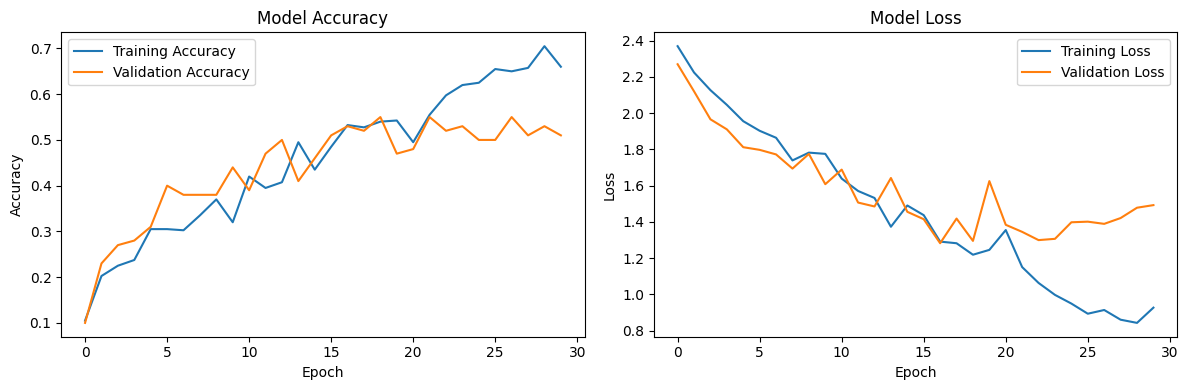

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step

CNN Classification Report:
              precision    recall  f1-score   support

       blues       0.31      0.50      0.38        10
   classical       0.53      0.80      0.64        10
     country       0.50      0.30      0.38        10
       disco       0.83      0.50      0.62        10
      hiphop       0.38      0.30      0.33        10
        jazz       0.30      0.30      0.30        10
       metal       0.70      0.70      0.70        10
         pop       0.70      0.70      0.70        10
      reggae       0.50      0.40      0.44        10
        rock       0.55      0.60      0.57        10

    accuracy                           0.51       100
   macro avg       0.53      0.51      0.51       100
weighted avg       0.53      0.51      0.51       100



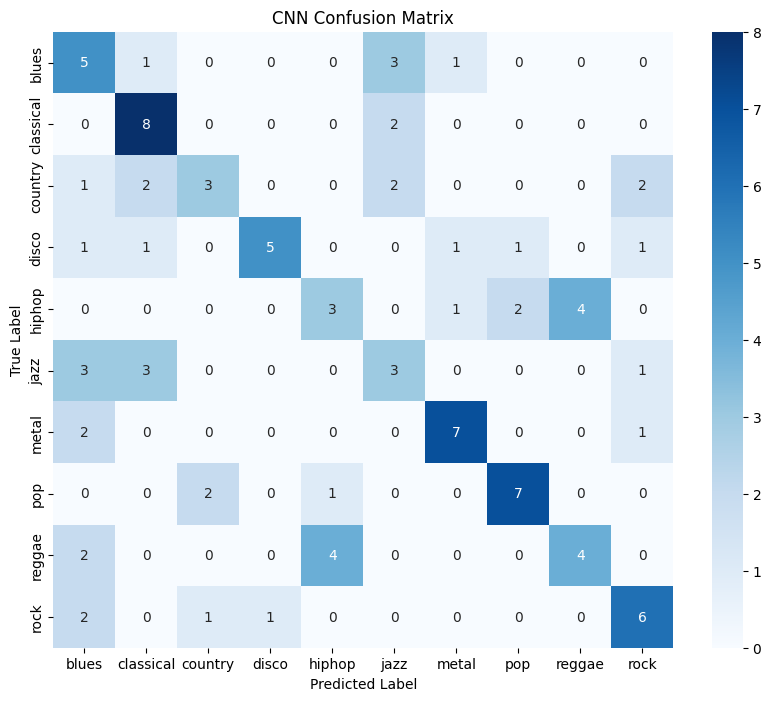

In [16]:
test_loss, test_acc = cnn_model.evaluate(X_test_img, y_test_img, verbose=0)
print(f'CNN Test accuracy: {test_acc:.4f}')
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()
y_pred_cnn = cnn_model.predict(X_test_img)
y_pred_classes = np.argmax(y_pred_cnn, axis=1)
y_true_classes = np.argmax(y_test_img, axis=1)
print("\nCNN Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('CNN Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Comparison of Approaches:
Random Forest Accuracy: 0.6900
CNN Accuracy: 0.5100


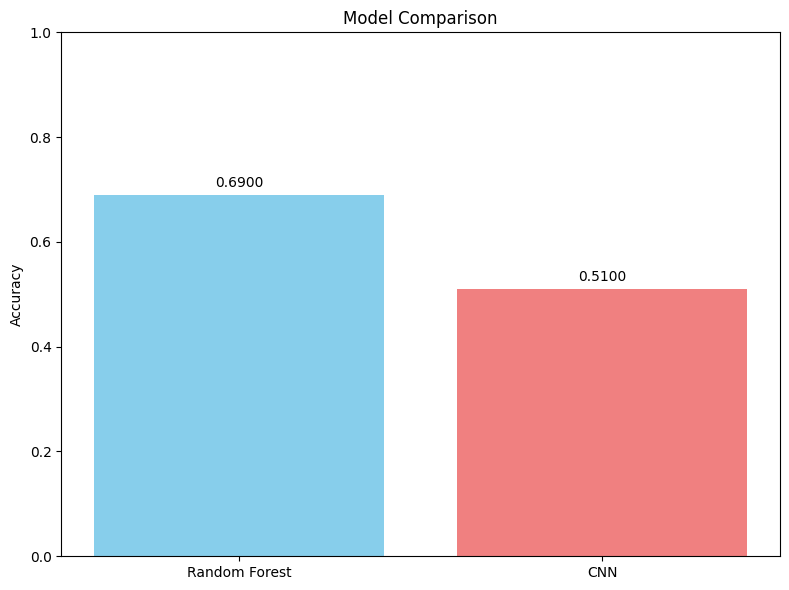

In [17]:
print("Comparison of Approaches:")
print(f"Random Forest Accuracy: {accuracy:.4f}")
print(f"CNN Accuracy: {test_acc:.4f}")
plt.figure(figsize=(8, 6))
models = ['Random Forest', 'CNN']
accuracies = [accuracy, test_acc]
colors = ['skyblue', 'lightcoral']
bars = plt.bar(models, accuracies, color=colors)
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.ylim(0, 1)
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{accuracy:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

#Music Genre Classification:

This project focused on building a system that could sort songs into different genres using their audio features. At first, it sounded pretty straightforward — “just figure out which genre a track belongs to” — but once I started working on it, I realized it was more complicated than it seemed. The biggest challenge was that genres aren’t always well-defined. Two songs in the same genre can sound completely different, while tracks from separate genres can sometimes share a lot of common elements. That made it tricky to capture what really sets one style apart from another.

I worked with the GTZAN dataset, which includes songs from ten different genres like classical, jazz, hip hop, and rock. It turned out to be a good balance: large enough to cover a variety of music but not so big that it became unmanageable. As I explored the data, I noticed that certain genres, such as classical, were much easier to distinguish, while others like rock and metal had significant overlap. This “blurring” between genres was something I had to keep in mind, since it could lead to frequent misclassifications.

Feature extraction was the first step, and although running the algorithms was fairly direct, deciding which features to use took some experimenting. I tested a few options and eventually relied on MFCCs (Mel-frequency cepstral coefficients) along with spectral features like centroid, rolloff, and bandwidth. These features capture the timbre and texture of music, even if the terms themselves don’t feel very intuitive at first.

For the actual modeling, I tried out two different approaches. The first was more traditional: training a Random Forest classifier on the extracted features. This gave me a solid baseline and showed that the model could pick up on meaningful patterns. The second approach was using convolutional neural networks with spectrograms, which felt like a completely different way of looking at the problem. Instead of manually designing features, the CNN learned directly from images of the audio signals. To my surprise, the CNN ended up performing slightly better, as it was able to detect subtle patterns the hand-crafted features might have missed.

Evaluating the results required more than just checking accuracy. I relied on confusion matrices to see which genres were being mixed up and used precision and recall to get a better sense of trade-offs. This was especially useful for genres with similarities, like hip hop and disco, which often share similar rhythmic structures.

A few unexpected things came up during testing. I assumed that the feature-based Random Forest model would outperform the CNN because of the carefully chosen features, but it was actually the other way around. I also noticed that some genres consistently gave the models trouble, which reminded me that music classification is rarely a clean-cut process.

In the end, what stood out to me was that genre classification isn’t just about labeling tracks — it’s about understanding what makes genres unique and also recognizing that the boundaries are often fuzzy. This project showed me that both traditional machine learning and deep learning approaches have their strengths, and the key is knowing when to use which. More than anything, it reinforced how much the “small” decisions — like preprocessing steps, feature choices, and evaluation methods — matter in building a system that’s actually useful.